In the previous notebook we've identified, analyzed and solved the inconsistences in our dataset. In some cases, for machine learning models, it is necessary to create new features to model the problem. This notebook aims to do the necessary feature engineering.

# Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline
sns.set_style("white")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn import metrics
from scipy import stats
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Get Data

In [5]:
df = pd.read_parquet('Concrete_Data_Cleaned.parquet')

# Feature Engineering

In [6]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,272.9,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,272.9,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,185.0,0.0,932.0,594.0,28,40.27
3,332.5,142.5,0.0,185.0,0.0,932.0,594.0,28,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28,44.30


The strength is the target variable, let's divide the dataset in dependent and independent variables and scale the data avoid data leakage.

In [7]:
df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [8]:
# spitting data into dependent and independent variables

X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age']]
y = df[['strength']]

In order to scale our data, let us use the z score.

In [9]:
Xscaled = X.apply(zscore)
X_scaled_df = pd.DataFrame(Xscaled, columns = df.columns)

In [10]:
X_scaled_df = X_scaled_df.drop(columns = 'strength')

In [11]:
X_scaled_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,0.147951,-0.830600,-0.822730,-1.004275,-0.618977,1.262346,-1.282281,0.300203
1,0.147951,-0.830600,-0.822730,-1.004275,-0.618977,1.496911,-1.282281,0.300203
2,0.892690,1.130849,-0.822730,0.396167,-1.156464,-0.426523,-2.543096,0.300203
3,0.892690,1.130849,-0.822730,0.396167,-1.156464,-0.426523,-2.543096,0.300203
4,-0.780475,0.991827,-0.822730,0.822389,-1.156464,0.299065,1.016402,0.300203
...,...,...,...,...,...,...,...,...
1025,0.191685,0.766088,0.642499,0.067368,0.756991,-1.394495,0.136906,0.300203
1026,0.763985,-0.830600,1.053023,1.065944,1.079483,-2.210781,0.830354,0.300203
1027,-1.406506,1.088179,0.939440,0.865011,0.155005,-1.045775,0.316803,0.300203
1028,-1.274052,1.739242,-0.822730,-0.176187,1.272979,0.474207,0.453647,0.300203


# Building Different Models

In [12]:
# splitting in train and test data
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size = 0.3, random_state = 1)

# Random Forest

In [13]:
# random forest model
model = RandomForestRegressor()
# fitting model
model.fit(X_train, y_train)
# predicted values
y_pred = model.predict(X_test)

In [14]:
# model performance on training data
model.score(X_train, y_train)

0.9649571234165295

In [15]:
# model performance on testing data
model.score(X_test, y_test)

0.8401559845641612

In [16]:
acc_R = metrics.r2_score(y_test, y_pred)

In [17]:
acc_R

0.8401559845641612

In [18]:
MSE = metrics.mean_squared_error(y_test, y_pred)

In [19]:
MSE

41.896267164944994

The model has overfitted because the train and test scores are supposed to be closer.

In [20]:
# store the accuracy results for each model in a dataframe for final comparison
results_1 = pd.DataFrame({'Algorithm':'Random Forest', 'accuracy': acc_R}, index = {'1'})
results = results_1[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156


## KFold cross validation

In [21]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
K_results = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(K_results))
accuracy

0.8622271558869248

In [22]:
# store the accuracy results for each model in a dataframe
random_re = pd.DataFrame({'Algorithm':['Random Forest Regressor k_fold'], 'accuracy': [accuracy]}, index = {'2'})
results = pd.concat([results, random_re])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227


# Gradient Boosting Regressor

In [23]:
# gradient boosting model
model = GradientBoostingRegressor()
# fitting model
model.fit(X_train, y_train)
# predicted values
y_pred = model.predict(X_test)

In [24]:
# model performance on training data
model.score(X_train, y_train)

0.9129121071009074

In [25]:
# model performance on testing data
model.score(X_test, y_test)

0.8302527218599342

In [26]:
acc_G = metrics.r2_score(y_test, y_pred)
acc_G

0.8302527218599342

In [27]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

44.49198361344398

In [28]:
# store the accuracy results for each model in a dataframe
gradient_re = pd.DataFrame({'Algorithm':['Gradient Boosting'], 'accuracy': [acc_G]}, index = {'3'})
results = pd.concat([results, gradient_re])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253


## KFold Cross Validation

In [29]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_3 = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(results_3))
accuracy

0.8554751073973492

In [30]:
# store the accuracy results for each model in a dataframe
gradient_k = pd.DataFrame({'Algorithm':['Gradient Boosting k_fold'], 'accuracy': [accuracy]}, index = {'4'})
results = pd.concat([results, gradient_k])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475


# Ada Boosting Regressor

In [31]:
# ada boosting model
model = AdaBoostRegressor()
# fitting model
model.fit(X_train, y_train)
# predicted values
y_pred = model.predict(X_test)

In [32]:
# model performance on training data
model.score(X_train, y_train)

0.7638031797203251

In [33]:
aa_Ada = metrics.r2_score(y_test, y_pred)
aa_Ada

0.7077312909213798

In [34]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

76.60573269586416

In [35]:
# store the accuracy results for each model in a dataframe
acc_Ada = pd.DataFrame({'Algorithm':['Ada Boosting'], 'accuracy': [aa_Ada]}, index = {'5'})
results = pd.concat([results, acc_Ada])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731


# K fold cross validation

In [36]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_4 = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(results_4))
accuracy

0.7238673786462161

In [37]:
# store the accuracy results for each model in a dataframe
acc_AdaC = pd.DataFrame({'Algorithm':['Ada Boosting k_fold'], 'accuracy': [accuracy]}, index = {'6'})
results = pd.concat([results, acc_AdaC])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867


# KNN Regressor

In [38]:
# checking for different values of neighbors to determine the best number

diff_k = []
for i in range(1, 45):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    diff_k.append(np.mean(pred_i != y_test))

Let us visualize the mean error for each value

Text(0, 0.5, 'Mean error')

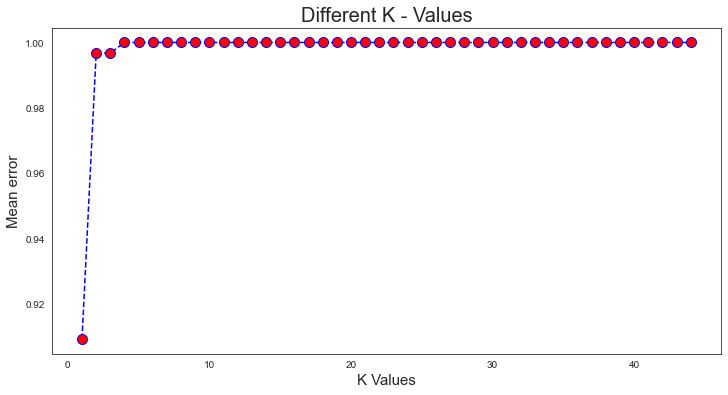

In [39]:
plt.figure(figsize = (12, 6))
plt.plot(range(1, 45), diff_k, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Different K - Values', fontsize = 20)
plt.xlabel('K Values', fontsize = 15)
plt.ylabel('Mean error', fontsize = 15)

In [40]:
# k = 3 is a better choice
model = KNeighborsRegressor(n_neighbors = 3)
# fitting model
model.fit(X_train, y_train)
# predicted values
y_pred = model.predict(X_test)

In [41]:
# model performance on training data
model.score(X_train, y_train)

0.8926750114787164

In [42]:
acc_KNN = metrics.r2_score(y_test, y_pred)
acc_KNN

0.7327995451983497

In [43]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

70.03516278317151

In [44]:
# store the accuracy results for each model in a dataframe
KNN_df = pd.DataFrame({'Algorithm':['KNN Regressor'], 'accuracy': [acc_KNN]}, index = {'7'})
results = pd.concat([results, KNN_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800


## kfold cross validation

In [45]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_5 = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(results_5))
accuracy

0.5648537541937363

In [46]:
# store the accuracy results for each model in a dataframe
KNNKfold_df = pd.DataFrame({'Algorithm':['KNN Regressor kfold'], 'accuracy': [accuracy]}, index = {'8'})
results = pd.concat([results, KNNKfold_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854


# Bagging Regressor

In [47]:
# bagging regressor model
model = BaggingRegressor()
# fitting model
model.fit(X_train, y_train)
# predicted values
y_pred = model.predict(X_test)

In [48]:
# model performance on training data
model.score(X_train, y_train)

0.9579376184061787

In [49]:
model.score(X_test, y_test)

0.8369428852219609

In [50]:
acc_BR = metrics.r2_score(y_test, y_pred)
acc_BR

0.8369428852219609

In [51]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

42.73844363368096

In [52]:
# store the accuracy results for each model in a dataframe
BR_df = pd.DataFrame({'Algorithm':['Bagging Regressor'], 'accuracy': [acc_BR]}, index = {'9'})
results = pd.concat([results, BR_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943


## Kfold cross validation

In [53]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_6 = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(results_6))
accuracy

0.8529692916591252

In [54]:
# store the accuracy results for each model in a dataframe
BaggingKfold_df = pd.DataFrame({'Algorithm':['Bagging Regressor kfold'], 'accuracy': [accuracy]}, index = {'10'})
results = pd.concat([results, BaggingKfold_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


# Support Vector Regressor

In [55]:
# support vector model
model = SVR(kernel = 'linear')
# fitting model
model.fit(X_train, y_train)
# predicted values
y_pred = model.predict(X_test)

In [56]:
# model performance on training data
model.score(X_train, y_train)

0.6672091931234319

In [57]:
model.score(X_test, y_test)

0.5691816797222073

In [58]:
acc_SVR = metrics.r2_score(y_test, y_pred)
acc_SVR

0.5691816797222073

In [59]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

112.92058321167713

In [60]:
# store the accuracy results for each model in a dataframe
SVR_df = pd.DataFrame({'Algorithm':['Bagging Regressor'], 'accuracy': [acc_SVR]}, index = {'11'})
results = pd.concat([results, SVR_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


## Kfold cross validation

In [61]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_7 = cross_val_score(model, X, y, cv = kfold)
accuracy = np.mean(abs(results_7))
accuracy

0.6249417071176954

In [62]:
# store the accuracy results for each model in a dataframe
BRKfold_df = pd.DataFrame({'Algorithm':['Bagging Regressor kfold'], 'accuracy': [acc_BR]}, index = {'12'})
results = pd.concat([results, BRKfold_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


# XGBoost Regressor

In [63]:
# xgboost regressor model
xgr = XGBRegressor()
# fitting model
xgr.fit(X_train, y_train)
# predicted values
y_pred = xgr.predict(X_test)

In [64]:
# model performance on training data
xgr.score(X_train, y_train)

0.9775344319902008

In [65]:
xgr.score(X_test, y_test)

0.8315259195769521

In [66]:
acc_XGB = metrics.r2_score(y_test, y_pred)
acc_XGB

0.8315259195769521

In [67]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

44.15826932604612

In [68]:
# store the accuracy results for each model in a dataframe
XGB_df = pd.DataFrame({'Algorithm':['XGBoost Regressor'], 'accuracy': [acc_XGB]}, index = {'13'})
results = pd.concat([results, XGB_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


## Kfold cross validation

In [69]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_8 = cross_val_score(xgr, X, y, cv = kfold)
accuracy = np.mean(abs(results_8))
accuracy

0.8691748222147225

In [70]:
# store the accuracy results for each model in a dataframe
XGBKFold_df = pd.DataFrame({'Algorithm':['XGBoost Regressor kfold'], 'accuracy': [accuracy]}, index = {'14'})
results = pd.concat([results, XGBKFold_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


# Decision Tree Regressor

In [71]:
# xgboost regressor model
dec_model = DecisionTreeRegressor()
# fitting model
dec_model.fit(X_train, y_train)
# predicted values
y_pred = dec_model.predict(X_test)

In [72]:
# Checking the feature importance
print('Feature importances: \n', pd.DataFrame(dec_model.feature_importances_, columns = ['Importance'], index = X_train.columns))

Feature importances: 
               Importance
cement          0.262189
slag            0.062382
ash             0.030395
water           0.207650
superplastic    0.034205
coarseagg       0.025863
fineagg         0.061014
age             0.316301


The most important features are age, cement and water.

In [73]:
y_pred = dec_model.predict(X_test)

In [74]:
# model performance on training data
dec_model.score(X_train, y_train)

0.9781185661281978

In [75]:
dec_model.score(X_test, y_test)

0.7651920348122582

In [76]:
acc_DT = metrics.r2_score(y_test, y_pred)
acc_DT

0.7651920348122582

In [77]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

61.54485806139878

In [78]:
# store the accuracy results for each model in a dataframe
DT_df = pd.DataFrame({'Algorithm':['Decision Tree Regressor'], 'accuracy': [acc_DT]}, index = {'15'})
results = pd.concat([results, DT_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


## Kfold cross validation

In [79]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_9 = cross_val_score(dec_model, X, y, cv = kfold)
accuracy = np.mean(abs(results_9))
accuracy

0.7868284320608908

In [80]:
# store the accuracy results for each model in a dataframe
DTKFold_df = pd.DataFrame({'Algorithm':['Decision Tree Regressor kfold'], 'accuracy': [accuracy]}, index = {'16'})
results = pd.concat([results, DTKFold_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


# Working with the most important features

In [81]:
df2 = df.copy() # create a copy in order to drop the least important features

In [82]:
# using the most important features as the X dataset
X = df2.drop(columns = ['strength', 'ash', 'coarseagg', 'fineagg'], axis = 1)
y = df2[['strength']]

In [83]:
# splitting into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [84]:
# scalling the train dependent variables
X_train = X_train.apply(zscore)
# scalling the test dependent variables
X_test = X_test.apply(zscore)

In [85]:
# decision tree regressor model with most important features
decNew_model = DecisionTreeRegressor()
# fitting the model
decNew_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [86]:
# Checking the feature importance again
print('Feature importances: \n', pd.DataFrame(decNew_model.feature_importances_, columns = ['Importance'], index = X_train.columns))

Feature importances: 
               Importance
cement          0.315359
slag            0.089117
water           0.221527
superplastic    0.055917
age             0.318081


In [87]:
y_pred = decNew_model.predict(X_test)

In [88]:
decNew_model.score(X_train, y_train)

0.9762602947409703

In [89]:
decNew_model.score(X_test, y_test)

0.6134571646737967

In [90]:
acc_DT = metrics.r2_score(y_test, y_pred)
acc_DT

0.6134571646737967

In [91]:
MSE = metrics.mean_squared_error(y_test, y_pred)
MSE

101.31565986605537

In [92]:
# store the accuracy results for each model in a dataframe
Dec_df1 = pd.DataFrame({'Algorithm':['Decision Tree 2'], 'accuracy': [acc_DT]}, index = {'17'})
results = pd.concat([results, Dec_df1])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


In [93]:
k = 20
# creating k experiments in the dataset and taking its mean accuracy
kfold = KFold(n_splits = k, random_state = 70, shuffle = True)
results_10 = cross_val_score(decNew_model, X, y, cv = kfold)
accuracy = np.mean(abs(results_10))
accuracy

0.8017093355830116

In [94]:
# store the accuracy results for each model in a dataframe
DTKFold_df = pd.DataFrame({'Algorithm':['Decision Tree 2 kfold'], 'accuracy': [accuracy]}, index = {'18'})
results = pd.concat([results, DTKFold_df])
results = results[['Algorithm', 'accuracy']]
results

,Algorithm,accuracy
1,Random Forest,0.840156
2,Random Forest Regressor k_fold,0.862227
3,Gradient Boosting,0.830253
4,Gradient Boosting k_fold,0.855475
5,Ada Boosting,0.707731
6,Ada Boosting k_fold,0.723867
7,KNN Regressor,0.732800
8,KNN Regressor kfold,0.564854
9,Bagging Regressor,0.836943
10,Bagging Regressor kfold,0.852969


In [95]:
results.sort_values(by = 'accuracy', ascending = False)

,Algorithm,accuracy
14,XGBoost Regressor kfold,0.869175
2,Random Forest Regressor k_fold,0.862227
4,Gradient Boosting k_fold,0.855475
10,Bagging Regressor kfold,0.852969
1,Random Forest,0.840156
9,Bagging Regressor,0.836943
12,Bagging Regressor kfold,0.836943
13,XGBoost Regressor,0.831526
3,Gradient Boosting,0.830253
18,Decision Tree 2 kfold,0.801709


As we can see, the best results were given by XGBoost and Random Forest regressors.